## Linear Regression Final Project: Logistic Regression with Traffic Collision Data
### Zachary Barnes and Bing Wang

##### Housekeeping

In [10]:
# Load Python libraries
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Read in and organize data from TIMS (Collisions and Victims)

#### Collisions data

In [2]:
c = pd.read_csv("Collisions.csv")

Response variable: Collision severity. We will code this as a binary variable, with 1 = fatality and 0 = not a fatality

Keep a subset of predictors as full model: Based on previous knowledge, these are likely to be predictors of collision severity

In [3]:
c = c[['CASE_ID','COLLISION_DATE','COLLISION_TIME','INTERSECTION','COLLISION_SEVERITY',
       'LIGHTING','LOCATION_TYPE', 'ROAD_SURFACE', 'ROAD_COND_1', 'PEDESTRIAN_ACCIDENT',
       'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'ALCOHOL_INVOLVED']]

Make datetime variables

In [4]:
# Convert COLLISION_TIME to hour of day (use tlater to match speeds to collisions)
c['COLLISION_TIME'] = [int(i[:-2]) if len(i) > 2 else 0 for i in c['COLLISION_TIME'].astype(str).values]

# Make Collision_Date a DateTime object
c["COLLISION_DATE"] = pd.to_datetime(c.COLLISION_DATE)

# Add quarter column (use later in match speeds to collisions)
c['QUARTER'] = c['COLLISION_DATE'].map(pd.to_datetime).dt.quarter

c.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,ALCOHOL_INVOLVED,POINT_X,POINT_Y,QUARTER
1634,8685953,2018-07-23,13,Y,4,A,NaN,A,H,Y,NaN,NaN,NaN,NaN,NaN,3
1597,8693161,2018-08-04,23,Y,4,B,NaN,A,D,NaN,NaN,NaN,NaN,-122.424580,37.801320,3
3699,90824986,2018-09-20,19,N,4,B,NaN,A,H,NaN,NaN,Y,NaN,-122.397267,37.781277,3
3231,8553198,2018-01-22,5,Y,4,C,NaN,B,D,Y,NaN,NaN,NaN,-122.422240,37.789400,1
307,8777403,2018-11-28,14,Y,3,A,NaN,B,H,NaN,NaN,NaN,NaN,-122.408690,37.780980,4


In [5]:
# recode variables in Collision (as 1s and 0s, reduce categories down, make dummies)

# NOTE: ROAD_SURFACE and ROAD_COND_1 had some observations unstated
# If not stated, assumed no issues with road surface or con'd

# Intersection: Make dummy, intersection/not
c.loc[c.INTERSECTION == "Y", "INTERSECTION"] = 1
c.loc[c.INTERSECTION == "N", "INTERSECTION"] = 0

# Lighting: Make 1, 2, 3 for ordinal values for light, dusk/dawn, dark
c.loc[c.LIGHTING == "A", "LIGHTING"] = 2  # Light
c.loc[c.LIGHTING == "B", "LIGHTING"] = 1  # Dusk/Dawn
c.loc[c.LIGHTING.isin(["C", "D", "E"]), "LIGHTING"] = 0  # Dark (w and w/o streetlight)

# Road_Surface: Convert to dummy, wet/not 
c.loc[c.ROAD_SURFACE.isin(["B", "C", "D"]), "WET_ROAD_SURFACE"] = 1
c.loc[~(c.ROAD_SURFACE.isin(["B", "C", "D"])), "WET_ROAD_SURFACE"] = 0

# Road_Cond_1: Convert to dummy, issue/not
c.loc[c.ROAD_COND_1.isin(["H", ""]), "ROAD_COND_ISSUE"] = 0
c.loc[~(c.ROAD_COND_1.isin(["H", ""])), "ROAD_COND_ISSUE"] = 1

# Location_Type: Convert to dummies for if Highway, if Ramp, or if

Recode some variables

In [6]:
# for dummies: recode Y as 1, blank as 0
def Yfor1(s):
    s = s.replace("Y", 1)
    s = s.fillna(0)
    return s

In [7]:
c["PEDESTRIAN_ACCIDENT"] = Yfor1(c.PEDESTRIAN_ACCIDENT)
c["BICYCLE_ACCIDENT"] = Yfor1(c.BICYCLE_ACCIDENT)
c["MOTORCYCLE_ACCIDENT"] = Yfor1(c.MOTORCYCLE_ACCIDENT)

In [8]:
c.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,ALCOHOL_INVOLVED,POINT_X,POINT_Y,QUARTER,WET_ROAD_SURFACE,ROAD_COND_ISSUE
364,8777319,2018-12-29,22,1,4,0,NaN,A,H,0.0,0.0,0.0,NaN,-122.393670,37.727040,4,0.0,0.0
1548,8697871,2018-08-29,18,1,4,2,NaN,A,H,0.0,1.0,0.0,NaN,-122.480910,37.755900,3,0.0,0.0
1411,8699908,2018-08-26,13,0,3,2,NaN,A,H,0.0,0.0,0.0,NaN,-122.431444,37.708927,3,0.0,0.0
2588,8605739,2018-03-27,12,1,2,2,NaN,A,-,0.0,1.0,1.0,NaN,-122.401790,37.802330,1,0.0,1.0
1200,8716545,2018-09-10,17,1,4,-,NaN,-,G,0.0,1.0,0.0,NaN,-122.452410,37.772150,3,0.0,1.0


Make response binary variable from Collision_Severity: 1 for fatality (COLLISION_SEVERITY = 1), 0 for not fatality (COLLISION_SEVERITY != 1)

In [9]:
c.loc[c.COLLISION_SEVERITY == 1, "Fatality"] = 1
c.loc[c.COLLISION_SEVERITY != 1, "Fatality"] = 0

Drop vars we won't use

### Exploratory Data Analysis

Make frequency bar charts

In [26]:
# value counts of response variable
c["Fatality"].value_counts()

0.0    3846
1.0      24
Name: Fatality, dtype: int64

In [24]:
# example of value counts by predictor (collision time)
c[["Fatality", "COLLISION_TIME", "CASE_ID"]].groupby(["Fatality", "COLLISION_TIME"]).count().reset_index()

,Fatality,COLLISION_TIME,CASE_ID
0,0.0,0,68
1,0.0,1,69
2,0.0,2,71
3,0.0,3,36
4,0.0,4,47
5,0.0,5,38
6,0.0,6,81
7,0.0,7,156
8,0.0,8,237
9,0.0,9,195


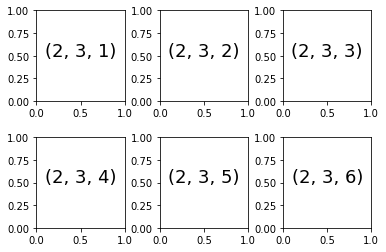

In [12]:
# example of grid plot...use this format to grid plot later? can we loop through things?
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.text(0.5, 0.5, str((2, 3, i)),
           fontsize=18, ha='center')

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range

In [ ]:
our_df.column_name.value_counts().plot(kind='bar')
plt.show()

In [27]:
len(c.columns)

19